In [1]:
!pip install contractions
!pip install emoji
!pip install mglearn
%matplotlib inline
!pip install pyLDAvis


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
# !pip install --upgrade pandas==1.5.3
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import re
import string
import contractions
import emoji
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import mglearn as mglearn
import matplotlib as plt
from __future__ import print_function
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

### Loading Data

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not running in Google Colab; skipping drive mount.")

Not running in Google Colab; skipping drive mount.


In [4]:
import sys


if 'google.colab' in sys.modules:
    df = pd.read_csv("drive/My Drive/AA/labelled_data.csv")
else:
    df = pd.read_csv("../Data/labelled_data.csv")

df = df[['text', 'label','readable_datetime']].dropna()
df.head()

,text,label,readable_datetime
0,naw dude if anything that gives you a solid co...,0,2023-06-10 15:54:27
1,OpenAI’s employees must be seriously regrettin...,-1,2024-08-06 05:10:21
2,Opinions: What AI product lived up to the hype...,0,2024-11-01 17:39:33
3,"You don’t need OpenAI to do this, in fact I’d ...",-1,2024-02-15 05:12:54
4,So for some reason I can't respond to any of t...,-1,2024-05-28 00:43:35


### Cleaning Text (Same as Part C Pipeline)

In [5]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, do_emoji_conversion=True, use_spacy_tokenizer=True):
        self.do_emoji_conversion = do_emoji_conversion
        self.use_spacy_tokenizer = use_spacy_tokenizer

    def remove_links(self, text):
        return re.sub(r'http[s]?://\S+|www\.\S+', '', text)

    def remove_user_mentions(self, text):
        return re.sub(r'u/\S+', '', text)

    def expand_contractions(self, text):
        return contractions.fix(text)

    def remove_non_ascii(self, text):
        return text.encode("ascii", "ignore").decode()

    def remove_punctuations(self, text):
        text = re.sub(r'[-]', ' ', text)
        text = re.sub(r'(\S)[' + re.escape(string.punctuation) + r']+', r'\1 ', text)
        text = re.sub(r'(\S)[' + re.escape(string.punctuation) + r'](\S)', r'\1 \2', text)
        return text

    def remove_numbers(self, text):
        return re.sub(r'[0-9]+', '', text)

    def emoji_to_text(self, text):
        return emoji.demojize(text)

    def normalize(self, text):
        return text.lower()

    def preprocess(self, text):
        text = self.normalize(text)
        text = self.remove_links(text)
        text = self.remove_user_mentions(text)
        text = self.expand_contractions(text)
        text = self.remove_non_ascii(text)
        text = self.remove_punctuations(text)
        text = self.remove_numbers(text)
        if self.do_emoji_conversion:
            text = self.emoji_to_text(text)
        text = self.normalize(text)
        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self.preprocess)

preprocessor = TextPreprocessor()

df['Cleaned_Text'] = preprocessor.fit_transform(df['text'])
df[['Cleaned_Text','text']].head()

,Cleaned_Text,text
0,naw dude if anything that gives you a solid co...,naw dude if anything that gives you a solid co...
1,openais employees must be seriously regretting...,OpenAI’s employees must be seriously regrettin...
2,opinions what ai product lived up to the hype...,Opinions: What AI product lived up to the hype...
3,you do not need openai to do this in fact i w...,"You don’t need OpenAI to do this, in fact I’d ..."
4,so for some reason i cannot respond to any of ...,So for some reason I can't respond to any of t...


In [6]:
print("Samples per class:\n")
print(df['label'].value_counts())

Samples per class:

label
 0    3923
-1    1170
 1     450
Name: count, dtype: int64


### Splitting Positive and Negative Data

This will help analyse the topic in the prominent sentiments of Positive and Negative

In [7]:
positive_df = df[df['label'] == 1]
negative_df = df[df['label'] == -1]

### LDA for Positive Reviews

In [8]:
pos_vect = CountVectorizer(max_features=10000, max_df=0.2, stop_words="english")
pos_X = pos_vect.fit_transform(positive_df['Cleaned_Text'])

In [9]:
pos_lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0)
pos_document_topics = pos_lda.fit_transform(pos_X)

In [10]:
pos_sorting = np.argsort(pos_lda.components_, axis=1)[:, ::-1]
pos_feature_names = np.array(pos_vect.get_feature_names_out())

mglearn.tools.print_topics(topics=range(10), feature_names=pos_feature_names, sorting=pos_sorting, topics_per_chunk=10, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      --------      --------      --------      --------      --------      
better        gpt           open          gpt           like          free          thanks        thank         make          gpt           
like          impressive    really        model         really        good          just          good          agi           did           
new           experience    model         great         use           think         open          gpt           like          good          
model         new           source        did           api           search        gpt           like          using         way           
just          bing          best          actually      using         models        model         open          use           use           
people       

The above keywords show that some relevant topics are performance improvements, capabilities, accessibility, general appreciation, API usage, community collaboration, learning, AGI advancements, and comparison with other models.

In [11]:
pyLDAvis.lda_model.prepare(pos_lda, pos_X, pos_vect, lambda_step=0.5)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.080463  0.064708       1        1  14.861932
0     -0.043379  0.066454       2        1  12.582997
7     -0.068794 -0.037959       3        1  11.977312
3      0.087219  0.051471       4        1  11.684738
8     -0.033987 -0.144243       5        1  10.501020
2     -0.019032  0.044405       6        1   9.399021
6      0.096201 -0.020139       7        1   8.476240
9      0.036837 -0.055356       8        1   7.555787
5     -0.054598  0.011475       9        1   7.331627
1      0.079994  0.019183      10        1   5.629327, topic_info=           Term       Freq      Total Category  logprob  loglift
1944      thank  17.000000  17.000000  Default  30.0000  30.0000
1325       open  42.000000  42.000000  Default  29.0000  29.0000
1576     really  40.000000  40.000000  Default  28.0000  28.0000
1946     thanks  19.000000  19.000000  Default  27.0000  27.0000
1175       make  18.000000  18.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
2009     trying   1.331542   5.814213  Topic10  -5.5731   1.4032
1579  reasoning   1.331541   9.969456  Topic10  -5.5731   0.8640
1441       plus   1.331541  10.927990  Topic10  -5.5731   0.7722
1104      level   1.331541   6.577108  Topic10  -5.5731   1.2799
551        does   1.331541  16.353857  Topic10  -5.5731   0.3691

[668 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.097348     able
2         2  0.194696     able
2         3  0.097348     able
2         4  0.097348     able
2         6  0.097348     able
...     ...       ...      ...
2177      3  0.175208      yes
2177      6  0.175208      yes
2177      8  0.350416      yes
2177     10  0.175208      yes
2181      8  0.702440  youtube

[1362 rows x 3 columns], R=30, lambda_step=0.5, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 8, 4, 9, 3, 7, 10, 6, 2])

### LSA for Positive Reviews

In [12]:
pos_lsa_model = TruncatedSVD(n_components=10, random_state=42)
pos_lsa_document_topics = pos_lsa_model.fit_transform(pos_X)

In [13]:
pos_lsa_sorting = np.argsort(pos_lsa_model.components_, axis=1)[:, ::-1]
pos_lsa_feature_names = np.array(pos_vect.get_feature_names_out())

mglearn.tools.print_topics(topics=range(10), feature_names=pos_lsa_feature_names, sorting=pos_lsa_sorting, topics_per_chunk=10, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      --------      --------      --------      --------      --------      
model         like          gpt           model         api           really        models        better        just          google        
gpt           gpt           better        new           use           good          access        just          new           models        
like          just          time          really        free          code          free          models        using         week          
just          people        access        using         whisper       access        really        good          access        agi           
open          things        fine          just          just          better        fine          mini          games         use           
really       

The above keywords show that some relevant topics are usability, API, general sentiment, model performance, accessibility, cost-efficiency, and comparison with other models.

### NNMF for Positive Reviews

In [14]:
pos_nmf_model = NMF(n_components=10, init='nndsvd', max_iter=80, random_state=42)
pos_nfm_document_topics = pos_nmf_model.fit_transform(pos_X)

In [15]:
pos_nfm_sorting = np.argsort(pos_nmf_model.components_, axis=1)[:, ::-1]
pos_nfm_feature_names = np.array(pos_vect.get_feature_names_out())

mglearn.tools.print_topics(topics=range(10), feature_names=pos_nfm_feature_names, sorting=pos_nfm_sorting, topics_per_chunk=10, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      --------      --------      --------      --------      --------      
like          model         gpt           open          api           really        ask           better        games         week          
just          new           access        source        free          good          learn         output        unique        agi           
people        whisper       fine          google        use           code          plan          tokens        game          years         
models        going         time          meta          whisper       just          python        prompt        experience    making        
things        using         results       free          available     access        set           siri          new           want          
great        

The above keywords show that some relevant topics are usability, model capabilities, accessibility, API usage, reasoning, search functionality, learning resources, Advancements, gaming experience, and comparisons with other models.

Overall, all three methods converge on key areas like model performance, accessibility, and comparisons with other models, but NNMF brings out a stronger focus on gaming and learning, while LDA and LSA emphasize the general appreciation and community aspects more strongly.

### LDA for Negative Reviews

In [16]:
neg_vect = CountVectorizer(max_features=10000, max_df=0.2, stop_words="english")
neg_X = neg_vect.fit_transform(negative_df['Cleaned_Text'])

In [17]:
neg_lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0)
neg_document_topics = neg_lda.fit_transform(neg_X)

In [18]:
neg_sorting = np.argsort(neg_lda.components_, axis=1)[:, ::-1]
neg_feature_names = np.array(neg_vect.get_feature_names_out())

mglearn.tools.print_topics(topics=range(10), feature_names=neg_feature_names, sorting=neg_sorting, topics_per_chunk=10, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      --------      --------      --------      --------      --------      
like          chatgpt       chatgpt       chatgpt       like          profit        like          chatgpt       access        open          
just          just          model         gpt           open          google        gpt           api           chatgpt       source        
chatgpt       open          really        did           does          non           data          just          like          chatgpt       
open          use           just          google        gpt           model         chatgpt       gpt           models        just          
better        model         good          api           source        just          just          google        google        does          
gpt          

The above keywords show distinct topics related to user dissatisfaction, with themes about issues with models, APIs, data handling, and comparisons with other models

In [19]:
pyLDAvis.lda_model.prepare(neg_lda, neg_X, neg_vect, lambda_step=0.5)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.073339  0.012389       1        1  15.123146
2      0.027609  0.037058       2        1  12.954782
1      0.038413  0.004449       3        1  12.216763
9      0.057674 -0.017290       4        1  11.407694
0      0.057042  0.049033       5        1  11.343250
7     -0.050080  0.089542       6        1  11.049096
6      0.042049 -0.099444       7        1   8.236038
8     -0.079379 -0.009546       8        1   6.114489
5     -0.073664 -0.111203       9        1   6.017033
3     -0.093002  0.045011      10        1   5.537708, topic_info=         Term        Freq       Total Category  logprob  loglift
3306   profit   35.000000   35.000000  Default  30.0000  30.0000
1873   google   60.000000   60.000000  Default  29.0000  29.0000
23     access   40.000000   40.000000  Default  28.0000  28.0000
211       api   80.000000   80.000000  Default  27.0000  27.0000
2917     open  139.000000  139.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
2736   models    2.969315   75.264445  Topic10  -5.8399  -0.3391
1869    going    2.967487   56.665406  Topic10  -5.8405  -0.0559
680   chinese    2.853274   18.100909  Topic10  -5.8798   1.0461
1969   having    2.853224   12.289465  Topic10  -5.8798   1.4333
4811    wrong    2.853221   20.587813  Topic10  -5.8798   0.9173

[716 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
15        7  0.866118  abusing
23        1  0.268663   access
23        2  0.024424   access
23        3  0.122120   access
23        4  0.024424   access
...     ...       ...      ...
4811      6  0.145717    wrong
4811      7  0.048572    wrong
4811     10  0.145717    wrong
4819      5  0.836241     yada
4837      6  0.627962     york

[1559 rows x 3 columns], R=30, lambda_step=0.5, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 10, 1, 8, 7, 9, 6, 4])

### LSA for Negative Reviews

In [20]:
neg_lsa_model = TruncatedSVD(n_components=10, random_state=42)
neg_lsa_document_topics = neg_lsa_model.fit_transform(neg_X)

In [21]:
neg_lsa_sorting = np.argsort(neg_lsa_model.components_, axis=1)[:, ::-1]
neg_lsa_feature_names = np.array(neg_vect.get_feature_names_out())

mglearn.tools.print_topics(topics=range(10), feature_names=neg_lsa_feature_names, sorting=neg_lsa_sorting, topics_per_chunk=10, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      --------      --------      --------      --------      --------      
chatgpt       chatgpt       open          gpt           just          like          api           data          profit        code          
like          api           chatgpt       api           code          chatgpt       use           profit        non           model         
just          using         source        version       open          looks         data          gpt           free          profit        
open          plus          deepseek      web           chatgpt       llms          models        microsoft     really        api           
gpt           data          censorship    variants      source        feels         using         non           people        data          
model        

The above keywords reveal several key topics related to user dissatisfaction with ChatGPT, API functionality, and issues surrounding accessibility and business practices.

### NNMF for Negative Reviews

In [22]:
neg_nmf_model = NMF(n_components=10, init='nndsvd', max_iter=80, random_state=42)
neg_nfm_document_topics = neg_nmf_model.fit_transform(neg_X)

In [23]:
neg_nfm_sorting = np.argsort(neg_nmf_model.components_, axis=1)[:, ::-1]
neg_nfm_feature_names = np.array(neg_vect.get_feature_names_out())

mglearn.tools.print_topics(topics=range(10), feature_names=neg_nfm_feature_names, sorting=neg_nfm_sorting, topics_per_chunk=10, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      --------      --------      --------      --------      --------      
model         chatgpt       open          gpt           just          like          api           data          profit        code          
free          plus          source        worse         people        did           does          use           non           issue         
better        using         models        users         really        agi           access        training      models        work          
google        subscription  closed        variants      going         feels         use           italy         business      comments      
deepseek      tools         censorship    chat          post          llms          version       collection    tax           error         
models       

The above keywords reveal several key topics related to user dissatisfaction with ChatGPT, including performance issues, accessibility concerns, and business practices.

Common topics of dissatisfaction include model performance issues, API problems, censorship, and accessibility issues related to subscriptions and business practices. Users also express competition from other models from Google and Microsoft.

### Topic modeling with respect to time

Dynamic topic modeling (DTM) is a collection of techniques aimed at analyzing the evolution of topics over time. These methods allow us to understand how a topic is represented across different times. BERTopic allows for DTM by calculating the topic representation at each timestep without the need to run the entire model several times.

How does BERTopic performs topic modeling?

BERTopic is a modern topic modeling technique that using transformer-based embeddings to create dense document representations, which are then clustered to identify topics. It performs a set of independent steps to achieve goal as listed below:

1) Document Embedding : Each document is encoded into a high-dimensional vector using a transformer model (e.g., BERT). This captures semantic nuances better than traditional bag-of-words methods.

2) Dimensionality Reduction: Dimensionality reduction technique like UMAP (Uniform Manifold Approximation and Projection) is applied.

3) Clustering: The reduced embeddings are clustered using HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise). HDBSCAN is particularly useful because it can find clusters of varying density and can also label outliers, which might not fit neatly into any topic.

4) Topic Representation: It uses class-based TF-IDF (c-TF-IDF) method. This computes a modified TF-IDF score across clusters rather than individual documents. The highest scoring words for each cluster are considered representative of the topic.


In [24]:
%pip install BERTopic

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Postive time based Topic Modeling

In BERTopic, the number of topics is initially determined by HDBSCAN, which clusters documents based on density without needing a pre-specified number of clusters. When we set n_topics="auto", BERTopic applies an additional topic reduction step that automatically merges similar topics. 

BERTopic calculates the similarity (typically using cosine similarity) between these topic representations. Topics with high similarity are merged together. This merging is usually performed through a hierarchical clustering approach on the c-TF-IDF vectors, ensuring that redundant or overly granular topics are consolidated into more meaningful ones.

In [50]:
from bertopic import BERTopic
import plotly.io as pio
from bertopic.representation import MaximalMarginalRelevance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Set a valid renderer
pio.renderers.default = "notebook_connected"  # For Jupyter Notebook

# Remove stop words from Cleaned_Text
def remove_stopwords(text):
	extra_stopwords = {"thank", "thanks"}
	all_stopwords = ENGLISH_STOP_WORDS.union(extra_stopwords)
	words = text.split()
	words = [word for word in words if word.lower() not in all_stopwords]
	return ' '.join(words)

In [68]:
#Create timestamped dataset
positive_df["readable_datetime"] = pd.to_datetime(positive_df["readable_datetime"], format='mixed', dayfirst=True)
positive_df = positive_df.sort_values(by="readable_datetime")

print(positive_df["readable_datetime"].describe())

positive_df['Cleaned_Text'] = positive_df['Cleaned_Text'].apply(remove_stopwords)


# Create your representation model
representation_model = MaximalMarginalRelevance(diversity=0.2)

# Fit BERTopic with correct parameters
topic_model = BERTopic(
	nr_topics="auto",
	min_topic_size=2,
	verbose=True,
	calculate_probabilities=True,
	representation_model=representation_model
)

topics, probs = topic_model.fit_transform(positive_df['Cleaned_Text'])

# Fine-tune topic representations after training BERTopic
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=5)
topic_model.update_topics(positive_df['Cleaned_Text'], vectorizer_model=vectorizer_model)

topic_info = topic_model.get_topic_info()
for topic in range(len(topic_info)):
	print(f"\nTopic {topic_info.iloc[topic]['Topic']}:")
	print("Words:", topic_info.iloc[topic]['Representation'])

# Generate topics over time with proper timestamps
docs = positive_df['Cleaned_Text'].tolist()
timestamps = positive_df["readable_datetime"].tolist()

# Generate topics over time with explicit parameters
topics_over_time = topic_model.topics_over_time(docs,
											  timestamps,
											  global_tuning=True,
											  evolution_tuning=True,
											  nr_bins=15)

# Visualize topics over time with specific parameters
fig = topic_model.visualize_topics_over_time(topics_over_time,
										   top_n_topics=10,
										   width=800,
										   height=500)
fig.show()

2025-02-19 21:44:24,932 - BERTopic - Embedding - Transforming documents to embeddings.


count                              450
mean     2024-03-10 10:22:50.342222336
min                2020-08-23 08:44:28
25%         2023-09-05 01:54:16.500000
50%                2024-05-15 02:16:35
75%      2024-10-13 22:30:30.249999872
max                2025-01-30 05:52:59
Name: readable_datetime, dtype: object


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2025-02-19 21:44:27,693 - BERTopic - Embedding - Completed ✓
2025-02-19 21:44:27,693 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-19 21:44:27,893 - BERTopic - Dimensionality - Completed ✓
2025-02-19 21:44:27,894 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-19 21:44:27,981 - BERTopic - Cluster - Completed ✓
2025-02-19 21:44:27,982 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-19 21:44:29,172 - BERTopic - Representation - Completed ✓
2025-02-19 21:44:29,173 - BERTopic - Topic reduction - Reducing number of topics
2025-02-19 21:44:29,766 - BERTopic - Topic reduction - Reduced number of topics from 64 to 31



Topic -1:
Words: ['use', 'ai', 'openai', 'chatgpt', 'free', 'api', 'gpt', 'better', 'help', 'open']

Topic 0:
Words: ['openai', 'ai', 'model', 'like', 'agi', 'gpt', 'open', 'really', 'just', 'new']

Topic 1:
Words: ['chatgpt', 'search', 'using', 'coding', 'works', 'just', 'code', 'lot', 'better', 'internet']

Topic 2:
Words: ['awesome', 'content', 'helpful', 'really good', 'good', 'forward', 'job', 'amazing', 'share', 'really']

Topic 3:
Words: ['free', 'access', 'user', 'able', 'maybe', 'preview', 'possible', 'quality', 'love', 'help']

Topic 4:
Words: ['reasoning', 'web', 'internet', 'better', 'search', 'amazing', 'superior', 'big', 'really good', 'doing']

Topic 5:
Words: ['tokens', 'quality', 'api', 'way', 'got', 'work', 'true', 'run', 'usage', 'preview']

Topic 6:
Words: ['complex', 'pro', 'far', 'best', 'model', 'superior', 'having', 'easy', 'idea', 'times']

Topic 7:
Words: ['reasoning', 'model', 'models', 'going', 'preview', 'does', 'especially', 'maybe', 'programming', 'faste

12it [00:00, 234.49it/s]


Note: Results may vary, but this some common obersavations from multiple observations. Attempts where made to keep randomization none, but HDBSCAN does add randomness

Upon evaluation we see that while general discussion about AI, GPT have continued since 2021, A exponential postivity spread after release of Chatgpt. It also people discussing a range of topics such as great UI, great source of information, free access and more..

We also see that people were quite positively impacted the mathemical capabilities, ever since the o1-preview was release in September 2024.

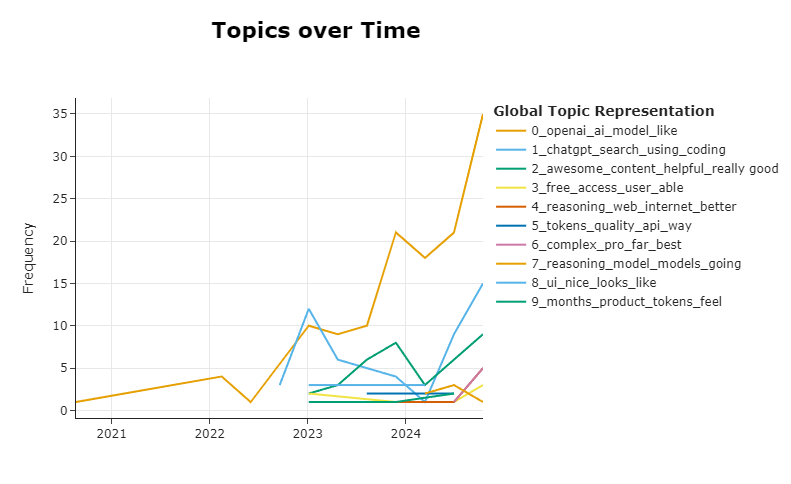

### Negative time based Topic Modeling

In [74]:
# For negative sentiment
# Create timestamped dataset
negative_df["readable_datetime"] = pd.to_datetime(negative_df["readable_datetime"], format='mixed', dayfirst=True)

# Create your representation model
representation_model = MaximalMarginalRelevance(diversity=0.3)

# Fit BERTopic with correct parameters
topic_model = BERTopic(
    nr_topics='auto',
    min_topic_size=2,
    verbose=True,
    calculate_probabilities=True,
    representation_model=representation_model
)


topics, probs = topic_model.fit_transform(negative_df['Cleaned_Text'])

# Fine-tune topic representations after training BERTopic
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=1)
topic_model.update_topics(negative_df['Cleaned_Text'], vectorizer_model=vectorizer_model)


topic_info = topic_model.get_topic_info()
for topic in range(len(topic_info)):
    print(f"\nTopic {topic_info.iloc[topic]['Topic']}:")
    print("Words:", topic_info.iloc[topic]['Representation'])

# Generate topics over time with proper timestamps
docs = negative_df['Cleaned_Text'].tolist()
timestamps = negative_df["readable_datetime"].tolist()

# Generate topics over time with explicit parameters
topics_over_time = topic_model.topics_over_time(docs,
                                              timestamps,
                                              global_tuning=True,
                                              evolution_tuning=True,
                                              nr_bins=15)

# Visualize topics over time with specific parameters
fig = topic_model.visualize_topics_over_time(topics_over_time,
                                           top_n_topics=10,
                                           width=800,
                                           height=500)

fig.show()

2025-02-19 21:50:02,335 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

2025-02-19 21:50:06,708 - BERTopic - Embedding - Completed ✓
2025-02-19 21:50:06,708 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-19 21:50:07,456 - BERTopic - Dimensionality - Completed ✓
2025-02-19 21:50:07,457 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-19 21:50:08,152 - BERTopic - Cluster - Completed ✓
2025-02-19 21:50:08,153 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-19 21:50:10,773 - BERTopic - Representation - Completed ✓
2025-02-19 21:50:10,774 - BERTopic - Topic reduction - Reducing number of topics
2025-02-19 21:50:12,773 - BERTopic - Topic reduction - Reduced number of topics from 142 to 108



Topic -1:
Words: ['ai', 'openai', 'like', 'open', 'just', 'chatgpt', 'models', 'open ai', 'code', 'know']

Topic 0:
Words: ['openai', 'profit', 'ai', 'open', 'company', 'technology', 'safety', 'non profit', 'microsoft', 'money']

Topic 1:
Words: ['gpt', 'really', 'just', 'like', 'teams', 'openai', 'users', 'audio', 'feel', 'pay']

Topic 2:
Words: ['api', 'azure', 'tokens', 'free', 'azure openai', 'openai api', 'openai', 'users', 'pay', 'request']

Topic 3:
Words: ['chatgpt', 'openai', 'privacy', 'data', 'users', 'chatgpt plus', 'make', 'api', 'using', 'chatgpt openai']

Topic 4:
Words: ['deepseek', 'model', 'data', 'nvidia', 'stole', 'companies', 'deepseek open', 'like nvidia', 'deepseek open source', 'deepseeks']

Topic 5:
Words: ['issue', 'having', 'problem', 'kind', 'openai', 'ip', 'ddos attack', 'ddos', 'outages', 'vps']

Topic 6:
Words: ['chatgpt', 'useful', 'complete', 'test coverage', 'clue', 'pasted', 'coverage', 'compared', 'hardly', 'compared chatgpt']

Topic 7:
Words: ['cha

15it [00:00, 22.87it/s]


Note: Results may vary, but this some common obersavations from multiple observations. Attempts where made to keep randomization none, but HDBSCAN does add randomness

Evaluation reveals that a major contribution to negativity is accounted by Open Ai being for profit and privacy of users data.

Thereafter,
The most expontential negative contributing factor to chatgpt was the release of the deepseek model, making it the biggest concern as of the time of cutoff of the data. The release of deepseek directly correlated to increase in discussions of copyrights, AI generated content, issues with open Ai, Token cost of Chatgpt.

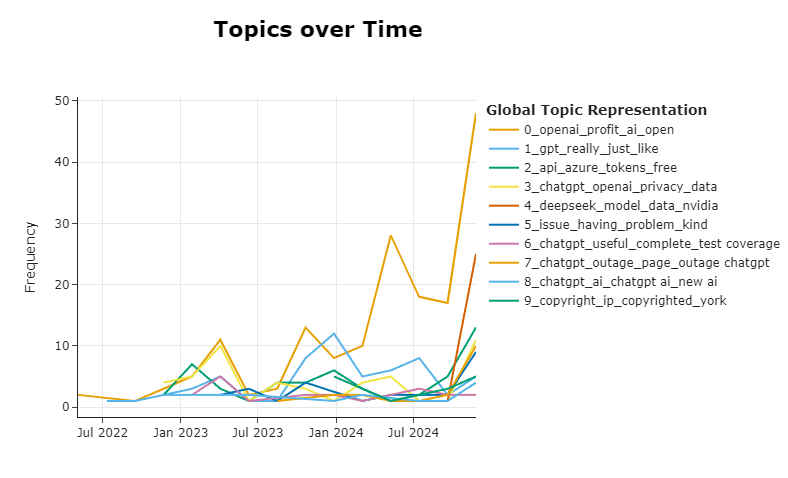